In [183]:
from main import *
from useful_functions import *
from visualization import *
from stats import *

%matplotlib inline
plt.rcParams['font.size'] = 12

In [184]:
delete = delete_rows_and_columns

color1 = [0, 0, 0]
color3 = [1, 1, 1]
blue = hex2rgb('#006DAA')
cmap = make_cmap([color1, blue, color3], [0, 0.5, 1])

# Replicating key results with sparse SC definition

# Replicating figure 2 results

In [185]:
atlas_path = '/home/anleg84/Documents/Atlas/MapzebrainOld/'
atlas = MapzebrainAtlas(atlas_path)

SC = np.load('Data/undirected_terminals.npy')
SC_dir = np.load('Data/directed_terminals.npy')
excluded = np.load('Results/excluded_regions.npy')

FC = np.load('Results/FC_matrix.npy')
R = FC.shape[0]
triangle = np.triu_indices(FC.shape[0], 1)

# Baseline SC-FC correlation

In [186]:
triangle = np.triu_indices(FC.shape[0], 1)

SC_FC_corr = pearsonr(FC[triangle], delete(SC, excluded)[triangle])[0]
print(SC_FC_corr)

0.48738177054601173


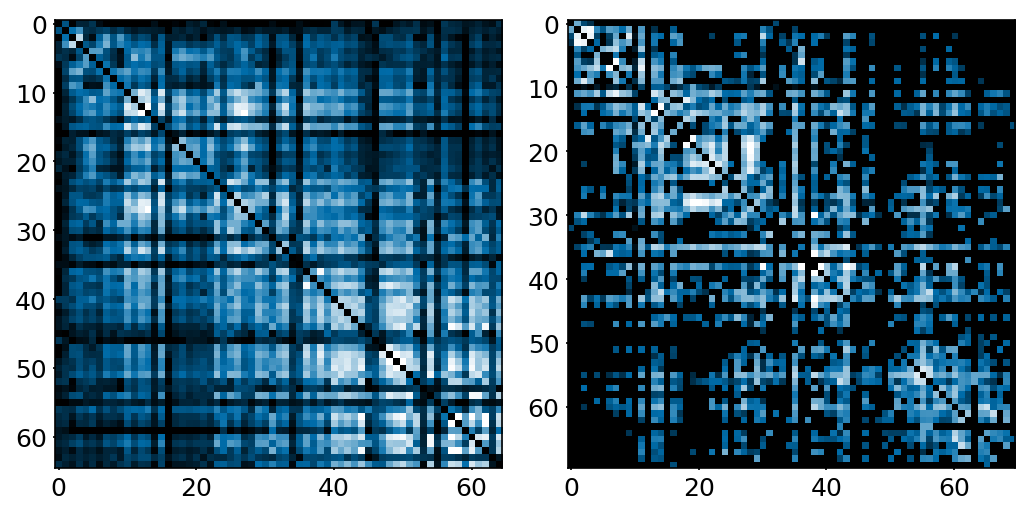

In [187]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5), dpi=150)
ax[0].imshow(FC, vmin=0.1, vmax=0.9, cmap=cmap)
ax[1].imshow(SC, vmin=0.1, vmax=0.9, cmap=cmap)

plt.tight_layout(pad=1)
#plt.savefig('Figures/Figure2/FC_SC_matrices.svg')

# Degrees correlation

Text(0, 0.5, 'Weighted functional degree')

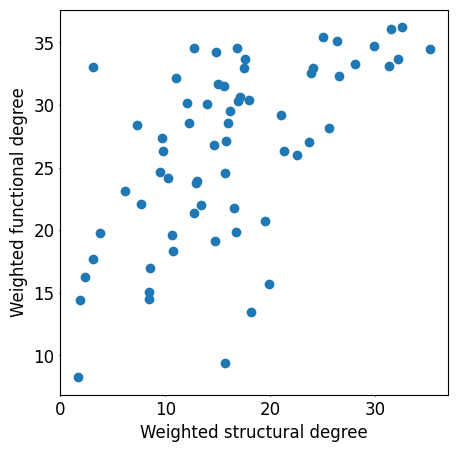

In [188]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(np.sum(delete(SC, excluded), axis=1), np.sum(FC, axis=1))
plt.xlabel('Weighted structural degree')
plt.ylabel('Weighted functional degree')

In [189]:
pearsonr(np.sum(delete(SC, excluded), axis=1), np.sum(FC, axis=1))

(0.5989947150047766, 1.3561197984873955e-07)

# FC of reciprocal pathways

In [190]:
def plot_smooth_histogram(ax, data, bins, N_interp=1000, sigma=20, density=False, color='black', edgecolor='black', alpha=1):
    h1 = np.histogram(data, bins=bins, density=density)
    #plt.close()
    y1 = gaussian_filter1d(interpolate_signal(h1[0], N_interp), sigma)
    x1 = interpolate_signal(h1[1], N_interp)
    ax.fill_between(x1, 0, y1, color=color, edgecolor=edgecolor, alpha=alpha)

def compute_directionality_distributions(networks, connectome):
    binary_connections = (connectome > 0).astype('int')
    number_of_connections = binary_connections + binary_connections.T
    corrs_0, corrs_1, corrs_2 = [], [], []
    triangle = np.triu_indices(connectome.shape[0], 1)
    for network in networks:
        corrs_0.append(network[triangle][number_of_connections[triangle] == 0])
        corrs_1.append(network[triangle][number_of_connections[triangle] == 1])
        corrs_2.append(network[triangle][number_of_connections[triangle] == 2])
    corrs_0 = np.array(corrs_0).flatten()
    corrs_0 = corrs_0[corrs_0 != 0]
    corrs_1 = np.array(corrs_1).flatten()
    corrs_1 = corrs_1[corrs_1 != 0]
    corrs_2 = np.array(corrs_2).flatten()
    corrs_2 = corrs_2[corrs_2 != 0]
    return corrs_0, corrs_1, corrs_2

In [191]:
FC_matrices = np.load('Results/FC_matrices.npy')

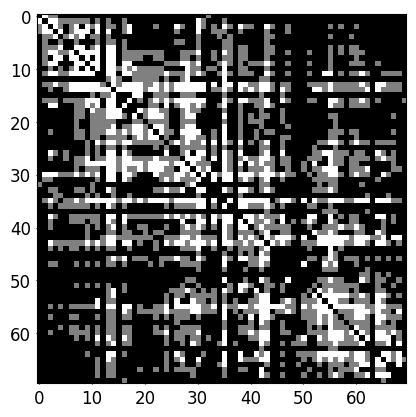

In [192]:
binary_connections = (SC_dir > 0).astype('int')
number_of_connections = binary_connections + binary_connections.T

plt.imshow(number_of_connections, cmap='gray')

#plt.savefig('Figures/Figure2/directionality_matrix.svg'))

In [193]:
corrs_0, corrs_1, corrs_2 = compute_directionality_distributions(FC_matrices, delete(SC_dir, excluded))

(0.0, 2.3)

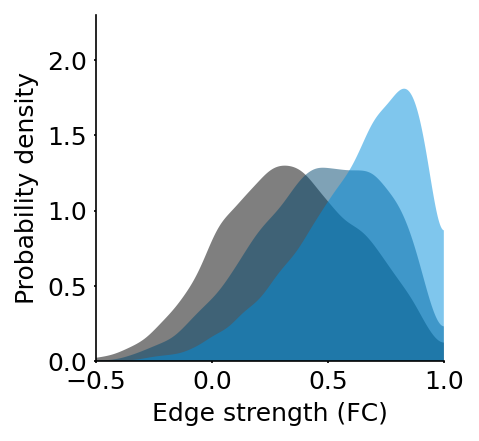

In [194]:
bins = np.linspace(-1, 1, 50)

fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
plot_smooth_histogram(ax, corrs_0, bins, sigma=20, color='black', edgecolor='none', alpha=0.5, density=True)
plot_smooth_histogram(ax, corrs_1, bins, sigma=20, color=0.65 * blue, edgecolor='none', alpha=0.5, density=True)
plot_smooth_histogram(ax, corrs_2, bins, sigma=20, color=1.3 * blue, edgecolor='none', alpha=0.5, density=True)
ax.spines[['top', 'right']].set_visible(False)
plt.xlabel('Edge strength (FC)')
plt.ylabel('Probability density')
plt.xlim([-0.5, 1])
plt.ylim([0, 2.3])

# Structural predictors of FC

In [195]:
from predictors import *

In [196]:
N_regions = FC.shape[0]

In [197]:
model = Predictors(SC_dir, SC, atlas.computeDistanceBetweenRegions(), excluded=excluded)
model.compute_predictors(directed=True)

In [198]:
correlations_single = model.correlate_single_predictors(FC)
Rsquared_single = []
for c in correlations_single:
    Rsquared_single.append(c ** 2)

In [199]:
baseline_corr = pearsonr(FC[triangle], delete(model.A_und, excluded)[triangle])[0]

Rsquared_baseline = baseline_corr ** 2

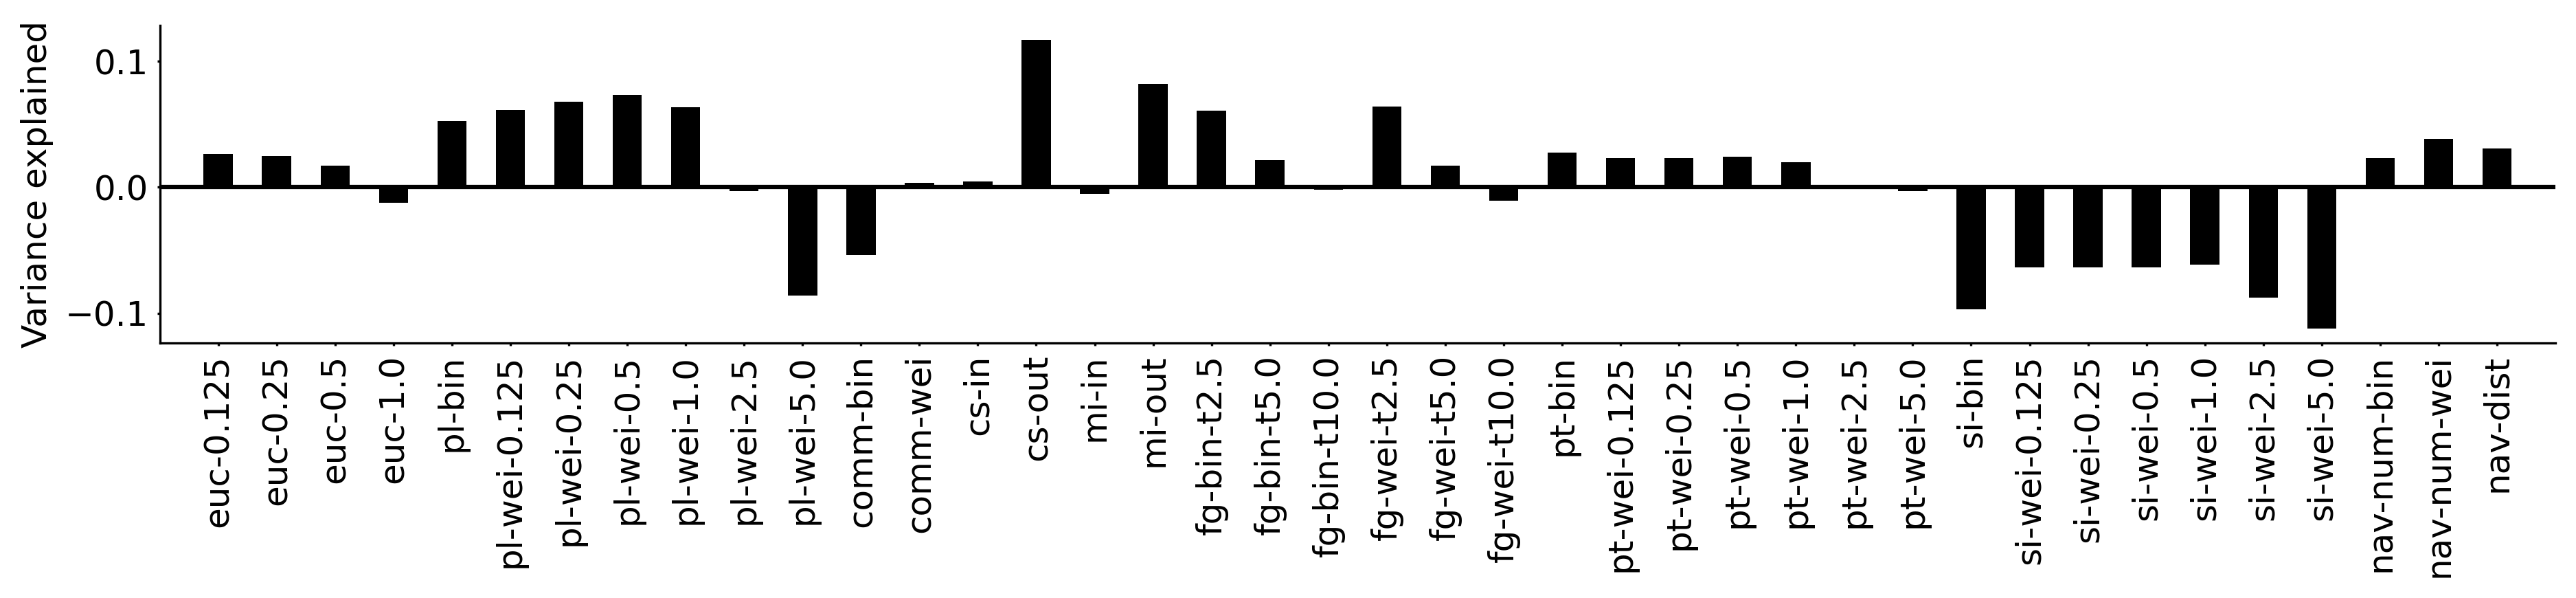

In [200]:
fig, ax = plt.subplots(figsize=(15, 2), dpi=300)
plt.bar(np.arange(model.predictors.shape[1]), np.abs(Rsquared_single) - Rsquared_baseline, color='black', width=0.5)
plt.plot([0 - 1, model.predictors.shape[1] ], [0, 0], color='black')
plt.xticks(np.arange(model.predictors.shape[1]), model.predictors_names, rotation=90)
plt.xlim([-1, model.predictors.shape[1] ])
ax.spines[['top', 'right']].set_visible(False)
plt.ylabel('Variance explained')
plt.show()

# Structural PC1

In [201]:
from sklearn.decomposition import PCA

In [202]:
predictors = model.predictors

In [203]:
interpredictor_correlations = np.corrcoef(predictors.T)[np.triu_indices(predictors.shape[1], 1)]

In [204]:
print('Mean +/- std')
print(np.mean(interpredictor_correlations), np.std(interpredictor_correlations))

Mean +/- std
0.6390826319741152 0.17554202737738006


In [205]:
predictors = model.predictors
mean_predictor = np.mean(predictors, axis=1).reshape(N_regions, N_regions)

In [206]:
pca = PCA(n_components=10).fit(predictors)
components = pca.fit_transform(predictors)
expvar = pca.explained_variance_ratio_
loadings = pca.components_.T

Text(0, 0.5, 'Explained variance')

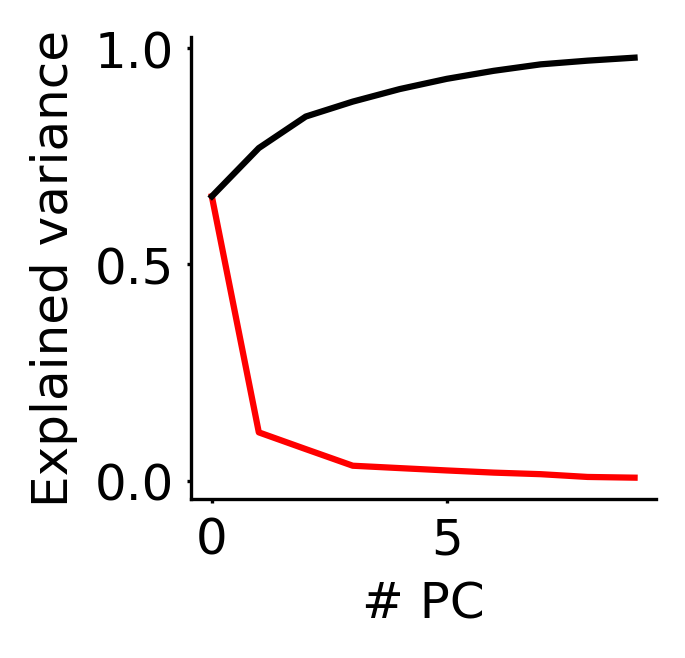

In [207]:
fig, ax = plt.subplots(figsize=(2, 2), dpi=300)
ax.plot(expvar[:10], color='red', label='Fraction of variance')
ax.plot(np.cumsum(expvar)[:10], color='black', label='Cumulative variance')
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('# PC')
ax.set_ylabel('Explained variance')

In [208]:
print(expvar[0])

0.6573742435527131


In [209]:
PCs = []
for i in range(components.shape[1]):
    PC = components[:, i].reshape(N_regions, N_regions)
    PC[np.diag_indices(PC.shape[0])] = 0
    PCs.append(np.sign(pearsonr(PC[triangle], FC[triangle])[0]) * PC)

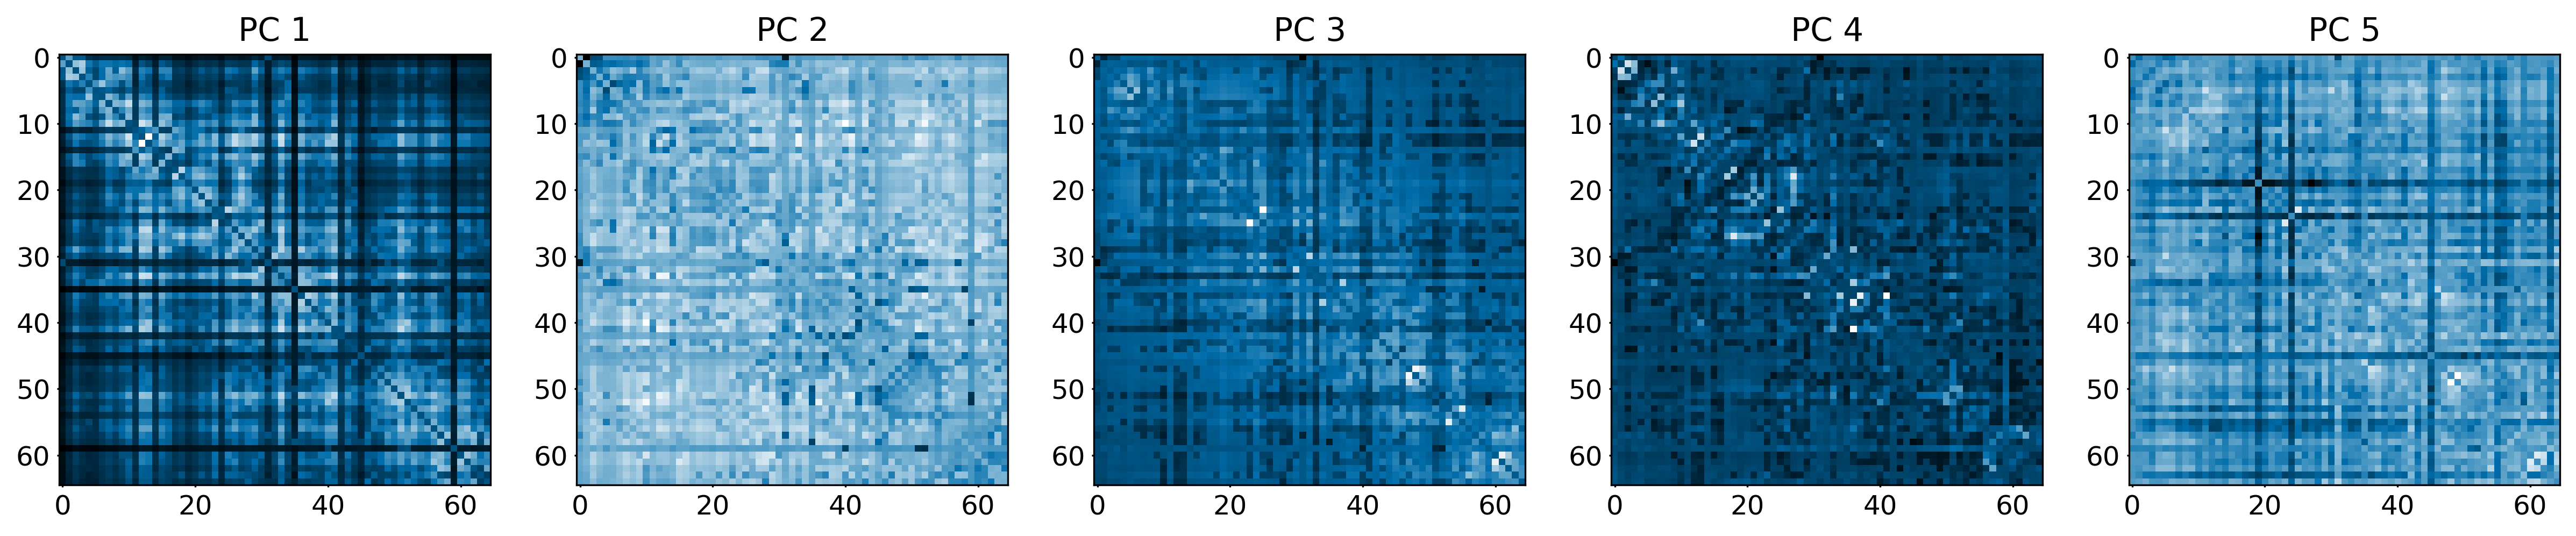

In [210]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4), dpi=300)
for i, PC in enumerate(PCs[:5]):
    ax[i].imshow(PC, cmap=cmap)
    ax[i].set_title('PC {}'.format(i + 1))

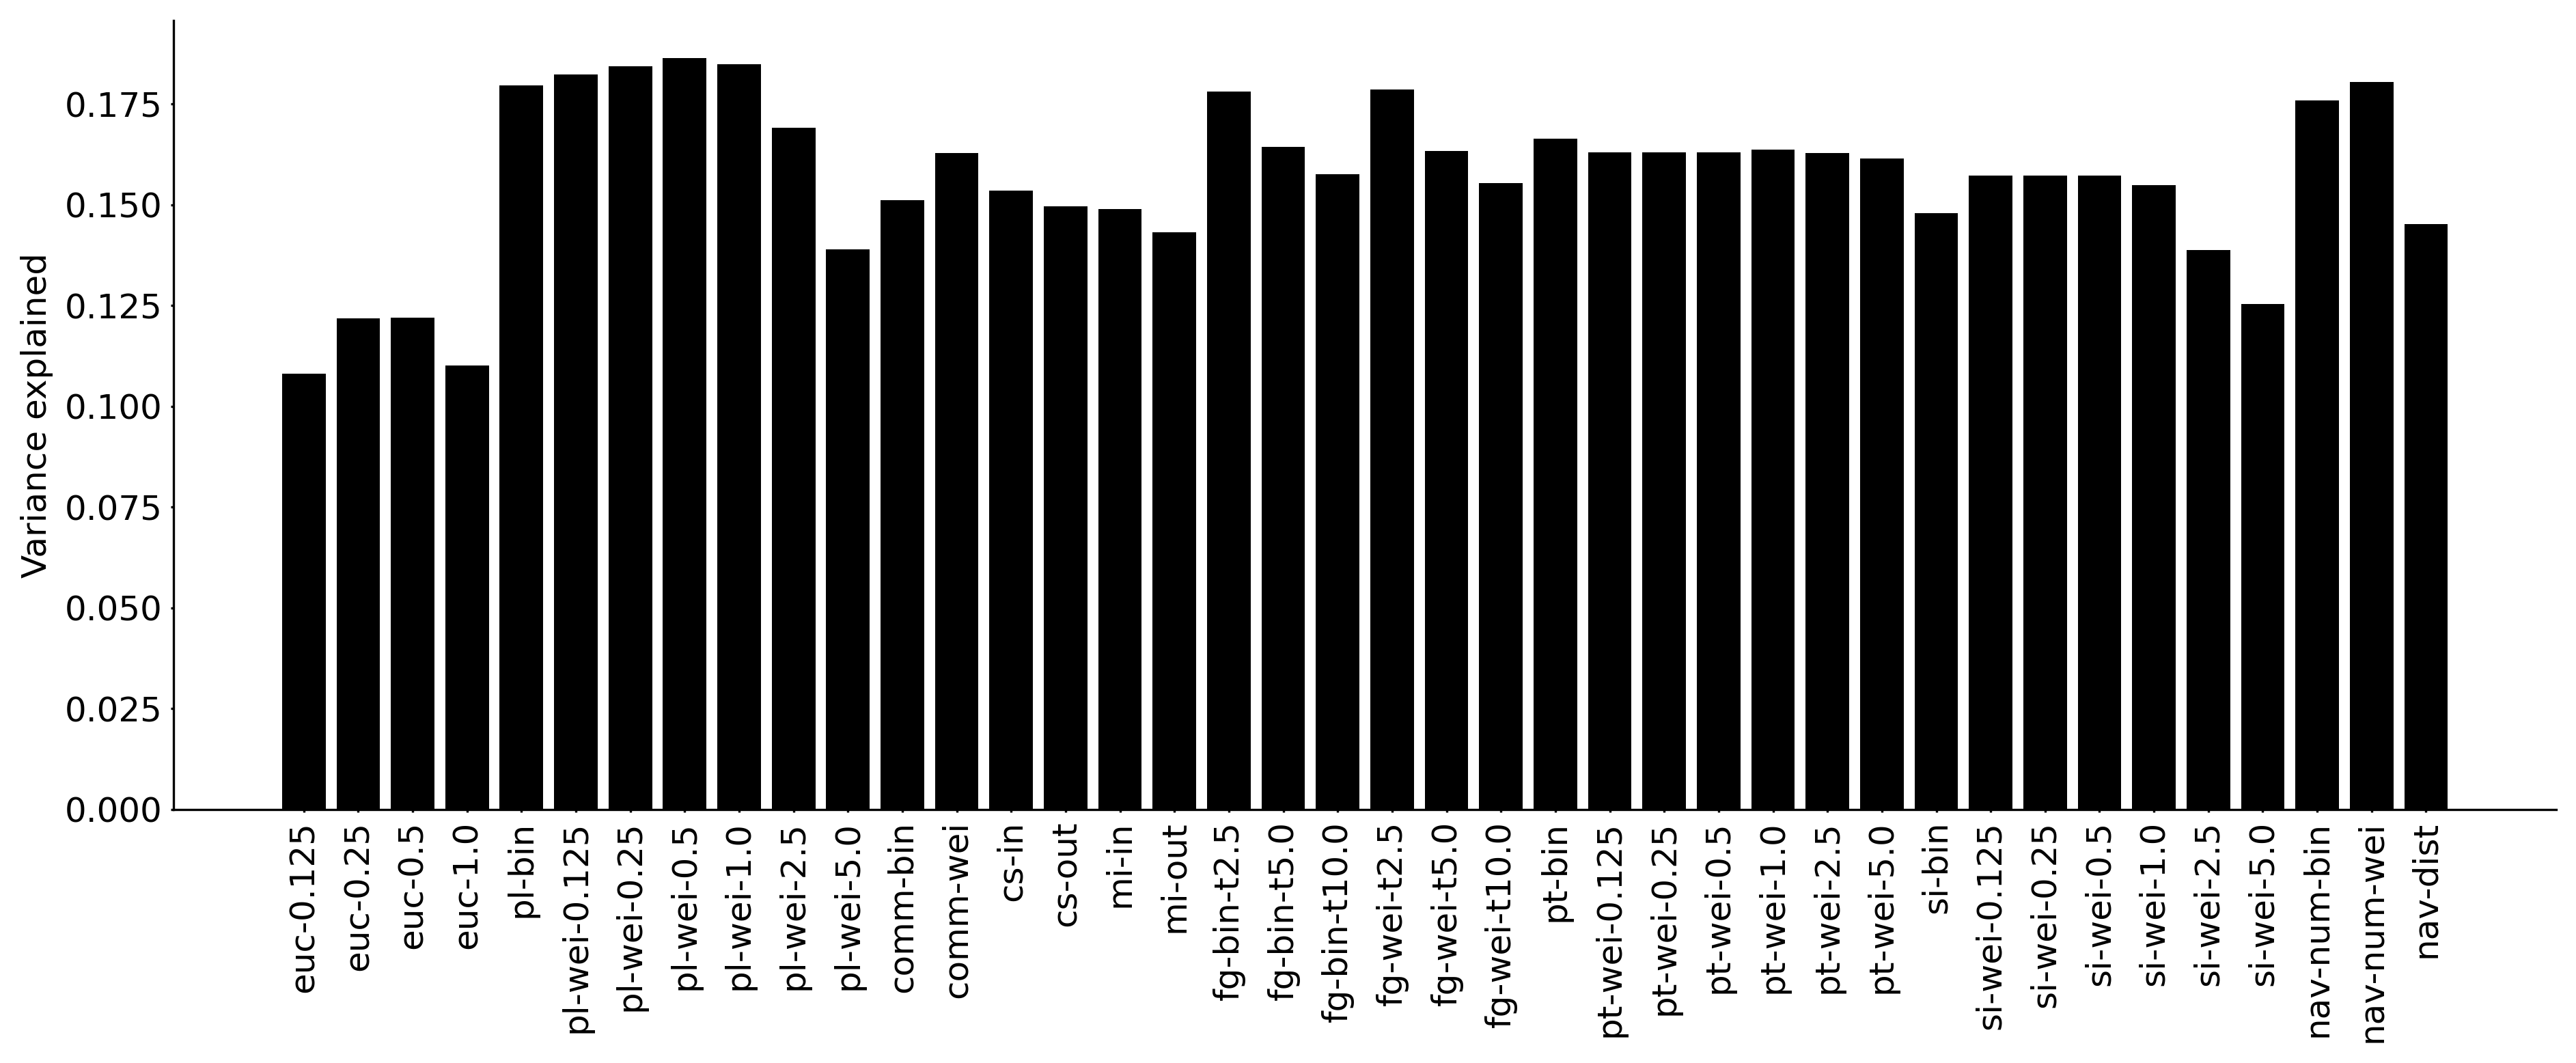

In [211]:
fig, ax = plt.subplots(figsize=(15, 5), dpi=300)
plt.bar(np.arange(model.predictors.shape[1]), loadings[:, 0], color='black', width=0.8)
plt.xticks(np.arange(model.predictors.shape[1]), model.predictors_names, rotation=90)
ax.spines[['top', 'right']].set_visible(False)
plt.ylabel('Variance explained')
plt.show()

In [212]:
def zscore_matrix(matrix):
    normalized = np.copy(matrix)
    normalized -= np.mean(matrix)
    normalized /= np.std(matrix)
    return normalized

def generate_half_matrix(M1, M2):
    triangle = np.triu_indices(M1.shape[0], 1)
    matrix = zscore_matrix(np.copy(M1))
    matrix[triangle] = zscore_matrix(M2)[triangle]
    return matrix

In [213]:
undirected = delete(model.A_und, excluded)

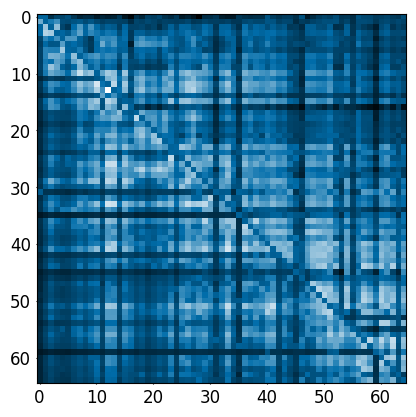

In [214]:
plt.imshow(generate_half_matrix(PCs[0], FC), cmap=cmap)

Text(0, 0.5, 'FC')

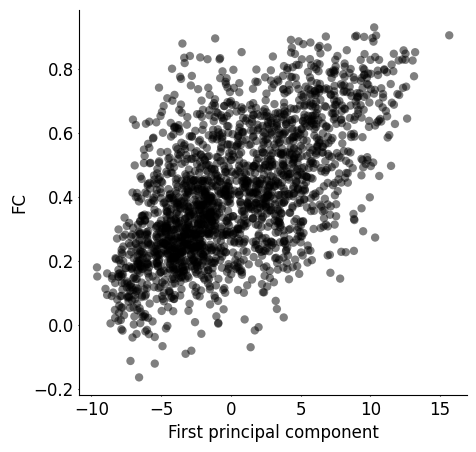

In [215]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(PCs[0][triangle], FC[triangle], color='black', alpha=0.5, edgecolor='None')

ax.spines[['top', 'right']].set_visible(False)
plt.xlabel('First principal component')
plt.ylabel('FC')

In [216]:
r_PC1 = pearsonr(PCs[0][triangle], FC[triangle])[0]
print(r_PC1)

0.6089479216679579


### Null model

In [217]:
distances = atlas.computeDistanceBetweenRegions()

In [219]:
null_SC_und, null_SC_dir = np.load('Results/null_SC_und_SCCM_sparse.npy'), np.load('Results/null_SC_dir_SCCM_sparse.npy')

In [ ]:
#null_predictor_correlations_SCCM = []
null_PC1_correlations_SCCM = []

for i in tqdm(range(1000), file=sys.stdout):

    model = Predictors(null_SC_dir[i], null_SC_und[i], distances, excluded=excluded)
    model.compute_predictors(directed=True)

    #corrs = model.correlate_single_predictors(FC)
    #R = []
    #for c in corrs:
    #    R.append(c ** 2)
    #null_predictor_correlations_SCCM.append(R)
    
    predictors = model.predictors
    
    pca = PCA(n_components=1).fit(predictors)
    components = pca.fit_transform(predictors)
    PC1 = components[:, 0].reshape(N_regions, N_regions)
    PC1[np.diag_indices(PC1.shape[0])] = 0

    null_r = pearsonr(PC1[triangle], FC[triangle])[0]
    
    null_PC1_correlations_SCCM.append(null_r)

  5%|██                                     | 52/1000 [16:35<4:58:24, 18.89s/it]

In [ ]:
np.save('Results/supp_null_PC1_correlations.npy', null_PC1_correlations)

# Replicating figure 3 results

#### Computing SC communities

In [35]:
W = SC_dir

In [36]:
compute = False
if compute:
    coassignment_matrix_SC = compute_coassignment_probability(W, N_iters=10000, threshold=False)
    np.save('Results/coassignment_matrix_SC.npy', coassignment_matrix_SC)
else:
    coassignment_matrix_SC = np.load('Results/coassignment_matrix_SC.npy')

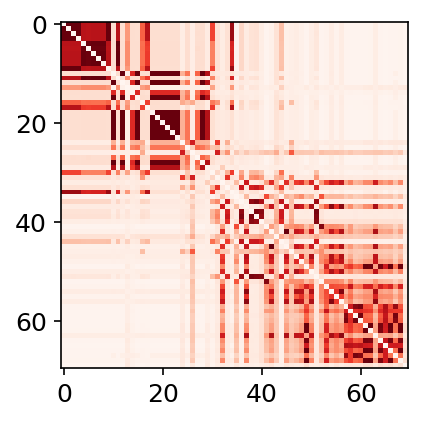

In [37]:
plt.figure(figsize=(3, 3), dpi=150)
plt.imshow(coassignment_matrix_SC, cmap='Reds')

In [38]:
C = coassignment_matrix_SC
Z = linkage(1-C, 'ward')
communities = reorder_clusters_anteroposterior(fcluster(Z, t=4, criterion='maxclust'))

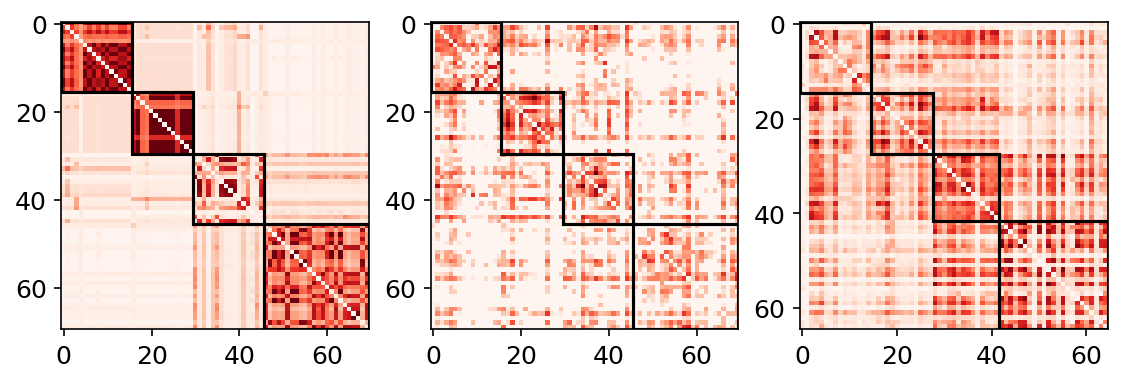

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3), dpi=150)
plot_matrix_communities(ax[0], C, communities, linewidth=1.5, cmap='Reds', edgecolor='black')
plot_matrix_communities(ax[1], SC ** 2, communities, linewidth=1.5, cmap='Reds', edgecolor='black')
plot_matrix_communities(ax[2], FC ** 2, np.delete(communities, excluded), linewidth=1.5, cmap='Reds', edgecolor='black')

#### Computing SCCM communities

In [40]:
SC_SCCM = np.load('Results/null_SC_dir_SCCM_sparse.npy')

compute = False
if compute:
    coassignment_null = []
    for s in SC_SCCM[:100]:
        C = compute_coassignment_probability(s, N_iters=1000, threshold=False)
        coassignment_null.append(C)
    np.save('Results/coassignment_SCCM_sparse.npy', np.stack(coassignment_null))
else:
    coassignment_SCCM = np.load('Results/coassignment_SCCM_sparse.npy')

# Overlap between functional and structural communities

In [41]:
N_max_FC = 7

In [42]:
method = 'Rand'
linkage_method = 'ward'

In [43]:
N_communities = np.arange(2, N_max_FC + 1)

In [44]:
coassignment_matrix_SC = np.load('Results/coassignment_matrix_SC.npy')
coassignment_matrix_FC = np.load('Results/coassignment_matrix_FC.npy')

In [45]:
scores_empirical = compute_communities_overlap_curve(coassignment_matrix_FC,
                                    coassignment_matrix_SC,
                                    excluded=excluded,
                                    method=method,
                                    linkage_method=linkage_method,
                                    N_communities=N_communities)

scores_SCCM = []
for C in coassignment_SCCM:
    scores = compute_communities_overlap_curve(coassignment_matrix_FC,
                                        C,
                                        excluded=excluded,
                                        method=method,
                                        linkage_method=linkage_method,
                                        N_communities=N_communities)
    scores_SCCM.append(scores)


scores_99_SCCM = np.percentile(np.stack(scores_SCCM), 99, axis=0)

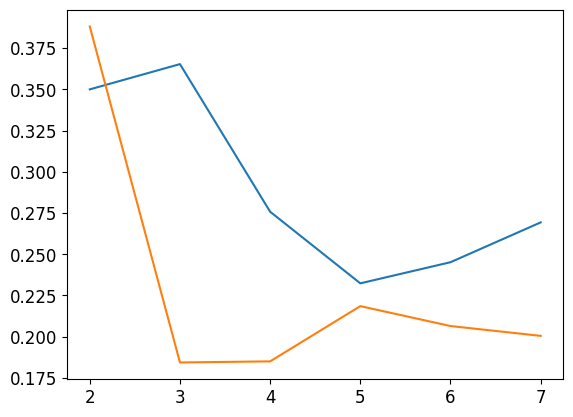

In [46]:
plt.plot(N_communities, scores_empirical)
plt.plot(N_communities, scores_99_SCCM, label='SCCM')


# Replicating figure 4 results

In [147]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, ward, leaves_list, set_link_color_palette
from brainsmash.mapgen.base import Base

def plot_surrogates(activation, distances, communities, n=10, resample=True):
    base = Base(x=activation, D=distances, resample=resample)
    surrogates = base(n=n)
    R = len(activation)
    cap = activation.reshape(R, 1) @ activation.reshape(1, R)
    surrogate_caps = []
    for s in surrogates:
        surrogate_caps.append(s.reshape(R, 1) @ s.reshape(1, R))

    fig, ax = plt.subplots(3, 5, figsize=(10, 7))
    v = np.percentile(np.abs(cap), 95)

    plot_matrix_communities(ax[0, 2], cap, communities, vmin=-v, vmax=v)
    for i, s in enumerate(surrogate_caps):
        a = ax.flatten()[i + 5]
        v = np.percentile(np.abs(s), 95)
        plot_matrix_communities(a, s, communities, vmin=-v, vmax=v)
    for i, a in enumerate(ax.flatten()):
        if i in [0, 1, 3, 4]:
            a.axis('off')
        else:
            a.set_xticks([])
            a.set_yticks([])
    plt.show()

def compute_mean_coactivation_per_module(vector, communities):
    V = vector.flatten()
    N = len(vector)
    matrix = V.reshape(N, 1) @ V.reshape(1, N)
    ids = np.argsort(communities)
    reordered_matrix = matrix[ids, :][:, ids]
    reordered_communities = communities[ids]
    mean_coactivation_per_module = []
    for c in np.unique(communities):
        block = reordered_matrix[reordered_communities == c, :][:, reordered_communities == c]
        mean_coactivation_per_module.append(np.mean(block))
    return mean_coactivation_per_module

def plot_significant_modules(coactivation_pattern, significant, communities, edgecolor='white'):
    R = coactivation_pattern.shape[0]
    if len(coactivation_pattern.shape) == 1:
        coactivation_pattern = coactivation_pattern.reshape(R, 1) @ coactivation_pattern.reshape(1, R)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    v = np.percentile(np.abs(coactivation_pattern), 95)
    plot_matrix_communities(ax[0], coactivation_pattern, communities, vmin=-v, vmax=v)
    significant_modules1 = np.zeros(coactivation_pattern.shape)
    significant_modules2 = np.zeros(coactivation_pattern.shape)

    for i, s in enumerate(significant):
        if s:
            significant_modules1[communities == i + 1, :] = 1
            significant_modules2[:, communities == i + 1] = 1
    plot_matrix_communities(ax[1], significant_modules1 * significant_modules2, communities, vmin=0, vmax=1, cmap='gray', edgecolor=edgecolor)
    plt.show()

In [148]:
excluded = np.load('Results/figure4_excluded_regions_bilateral.npy')
events = np.load('Results/figure4_events_high.npy')
clusters = np.load('Results/figure4_clusters_events_high.npy')

In [149]:
cluster_centroids = []
for c in np.unique(clusters):
    if c != -1:
        centroid = np.mean(events[:, clusters == c], axis=1)
        cluster_centroids.append(centroid)

In [150]:
centroids = np.concatenate([atlas.regionCentroids['left'], atlas.regionCentroids['right']], axis=0)
centroids[:, 1] = 974 - centroids[:, 1]
centroids = np.delete(centroids, excluded, axis=0)

distances = compute_distances(centroids)

In [151]:
coassignment_matrix_SC = np.load('Results/coassignment_matrix_SC_sparse.npy')
coassignment_matrix_SCCM = np.load('Results/coassignment_SCCM_sparse.npy')

#### Cluster 1 (Visual)

In [152]:
coassignment_matrix = coassignment_matrix_SC

c = cluster_centroids[1]
surrogates = np.load('Results/figure4_surrogates_cluster1.npy')

In [153]:
%matplotlib inline

100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 9351.84it/s]


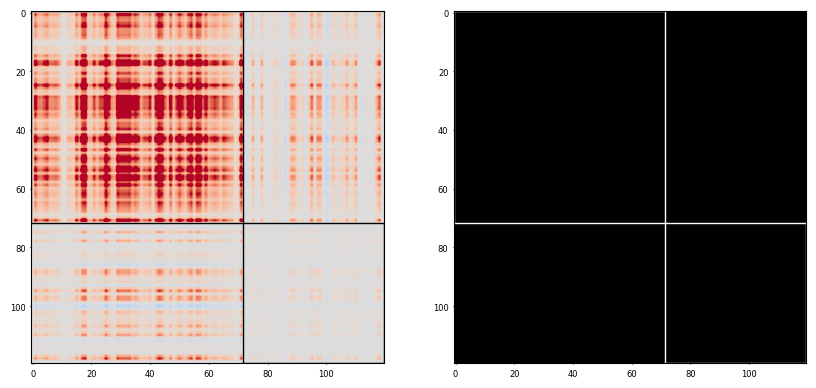

P-value: 0.234

100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 8698.77it/s]


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x77432c85db50>>
Traceback (most recent call last):
  File "/home/anleg84/anaconda3/envs/calimba/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


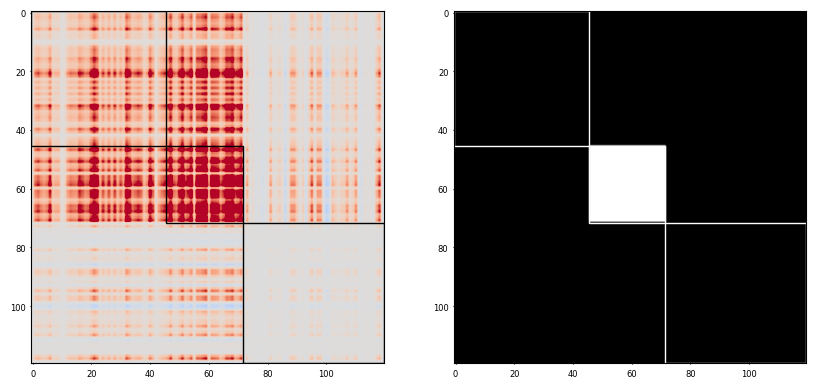

P-value: 0.006

100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 7667.07it/s]


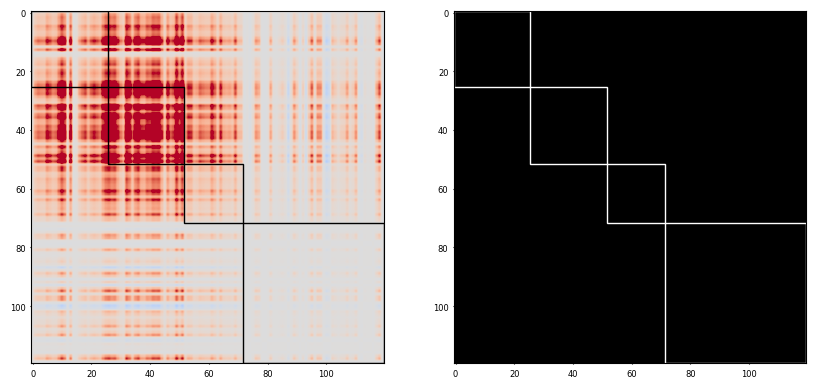

P-value: 0.079

100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 6581.84it/s]


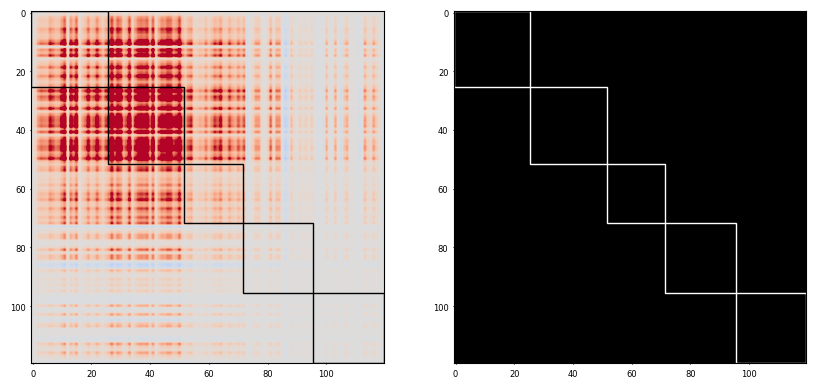

P-value: 0.139

100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 6010.92it/s]


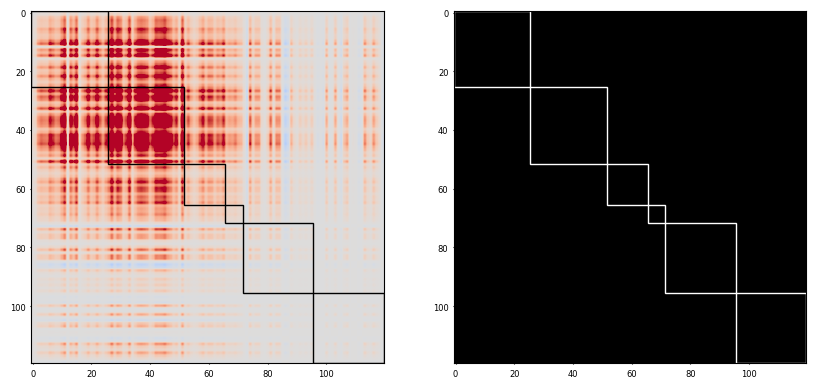

P-value: 0.160

100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 6111.25it/s]


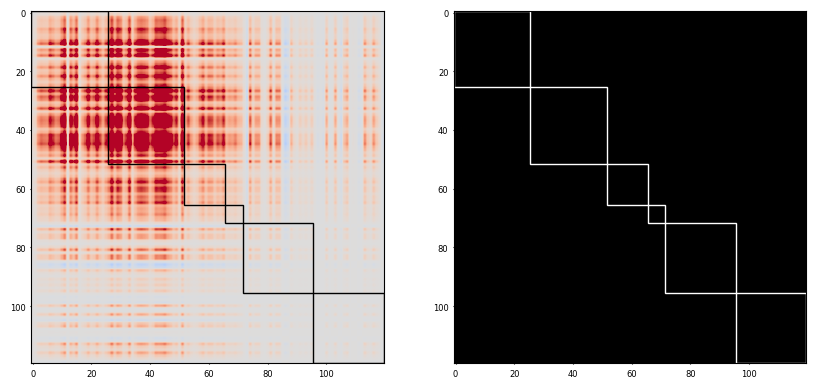

P-value: 0.160

100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 5520.99it/s]


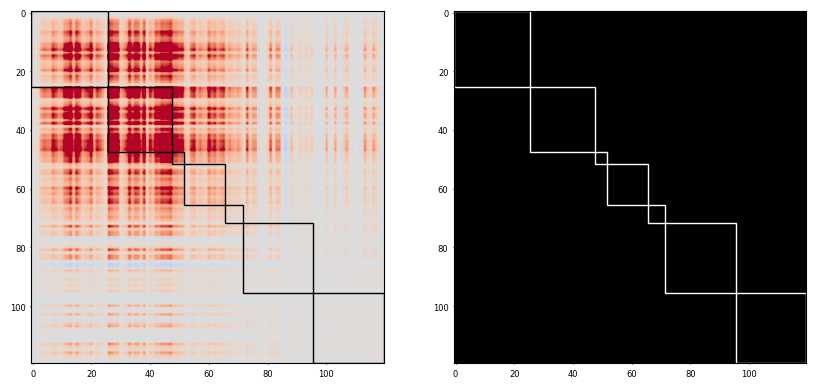

P-value: 0.165

100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4906.59it/s]


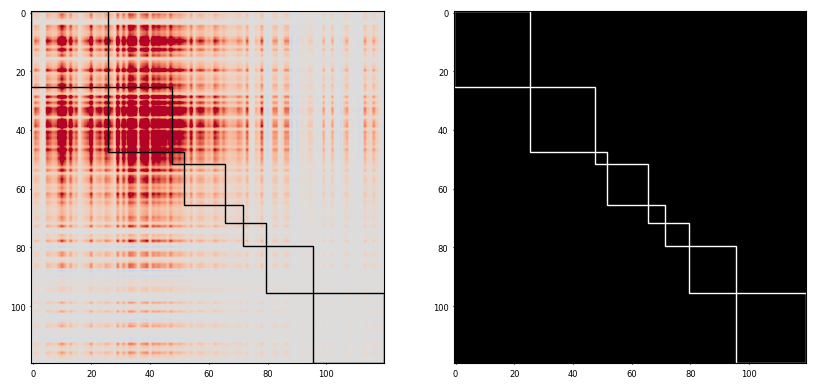

P-value: 0.167

100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4585.82it/s]


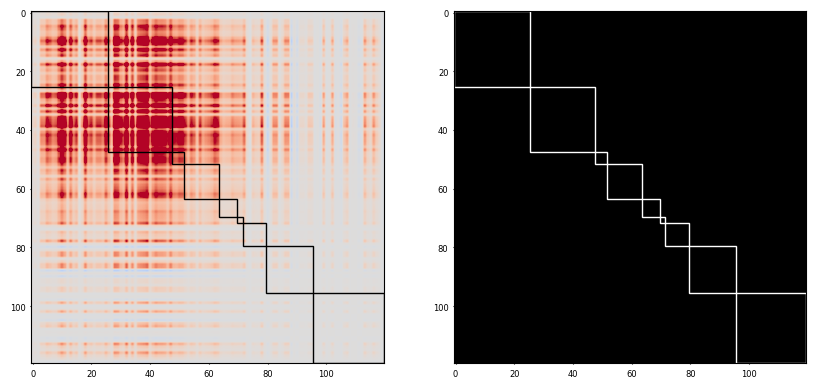

P-value: 0.246



In [154]:
coassignment_matrix = coassignment_matrix_SC

for N_communities in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
    Z = linkage(1 - coassignment_matrix, 'ward')
    ids_Z = np.flip(leaves_list(Z)).astype('int')
    communities = reorder_clusters_anteroposterior(fcluster(Z, t=N_communities, criterion='maxclust'))
    communities = np.delete(double(communities), excluded)
    
    mean_coactivation = compute_mean_coactivation_per_module(c, communities)
    null_coactivations = []
    for s in tqdm(surrogates, file=sys.stdout):
        mean_null = compute_mean_coactivation_per_module(s, communities)
        null_coactivations.append(mean_null)
    threshold = np.percentile(np.max(null_coactivations, axis=1), 95)
    p_value = (100 - percentileofscore(np.max(null_coactivations, axis=1), np.max(mean_coactivation))) / 100
    significant = mean_coactivation > threshold
    plot_significant_modules(c, significant, communities, edgecolor='white')
    
    print('P-value: {:.3f}\n'.format(p_value))

#### Cluster 2 (motor)

In [128]:
c = cluster_centroids[2]
surrogates = np.load('Results/figure4_surrogates_cluster2.npy')

100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 9158.70it/s]


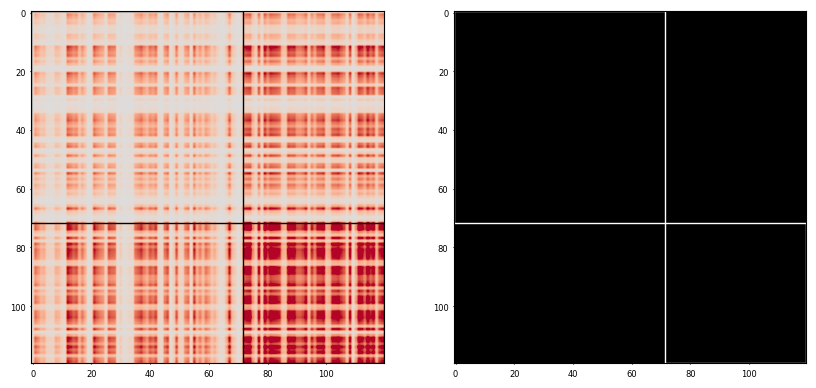

P-value: 0.091

100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 8025.51it/s]


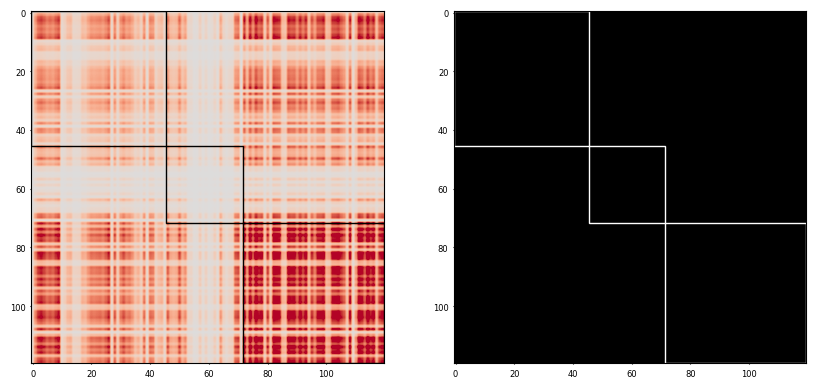

P-value: 0.195

100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 7205.74it/s]


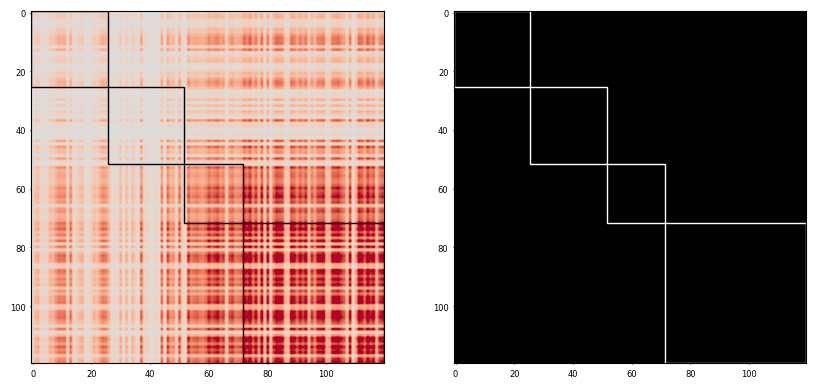

P-value: 0.440

100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 6578.89it/s]


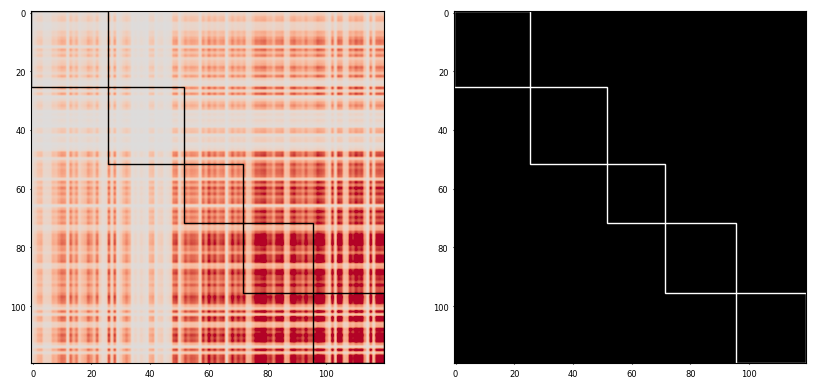

P-value: 0.548

100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 6173.51it/s]


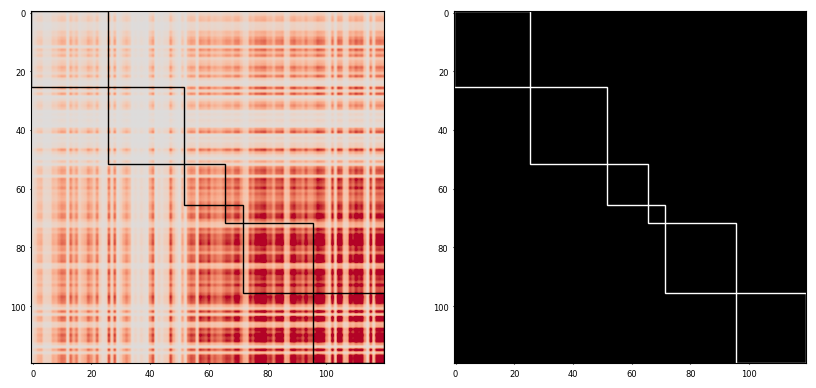

P-value: 0.595

100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 5705.00it/s]


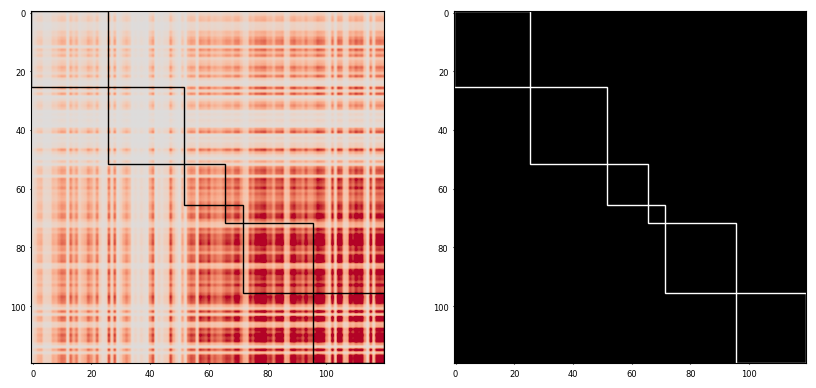

P-value: 0.595

100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 5098.39it/s]


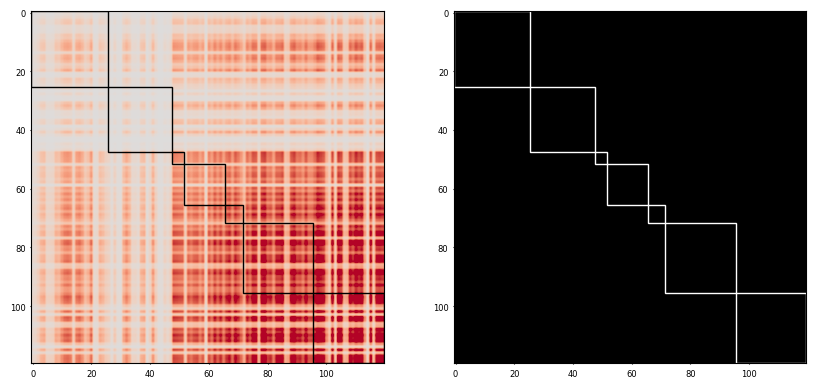

P-value: 0.669

100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4293.50it/s]


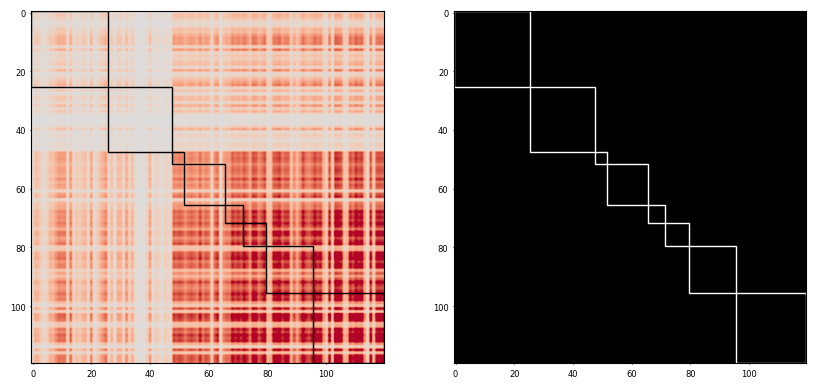

P-value: 0.388

100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4821.86it/s]


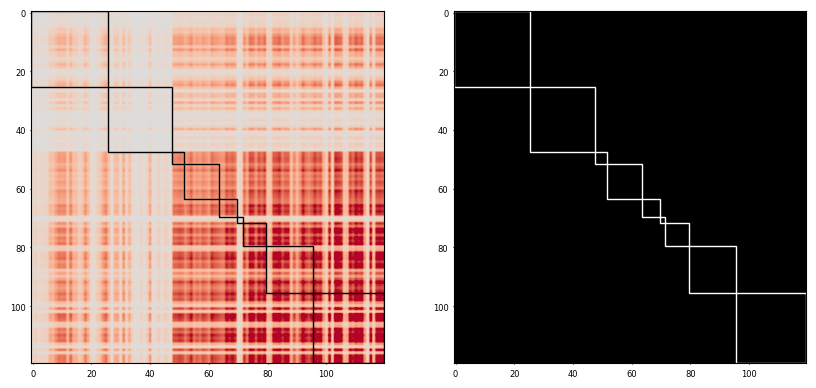

P-value: 0.490



In [129]:
for N_communities in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
    
    Z = linkage(1 - coassignment_matrix, 'ward')
    ids_Z = np.flip(leaves_list(Z)).astype('int')
    communities = reorder_clusters_anteroposterior(fcluster(Z, t=N_communities, criterion='maxclust'))
    communities = np.delete(double(communities), excluded)
    
    mean_coactivation = compute_mean_coactivation_per_module(c, communities)
    null_coactivations = []
    for s in tqdm(surrogates, file=sys.stdout):
        mean_null = compute_mean_coactivation_per_module(s, communities)
        null_coactivations.append(mean_null)
    threshold = np.percentile(np.max(null_coactivations, axis=1), 95)
    p_value = (100 - percentileofscore(np.max(null_coactivations, axis=1), np.max(mean_coactivation))) / 100
    significant = mean_coactivation > threshold
    plot_significant_modules(c, significant, communities, edgecolor='white')
    
    print('P-value: {:.3f}\n'.format(p_value))

#### 3. Forebrain ICA

In [168]:
c = np.load('Results/figure4_forebrain_active.npy')
forebrain_active = c
surrogates = np.load('Results/figure4_surrogates_forebrain_active.npy')

100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 8404.28it/s]


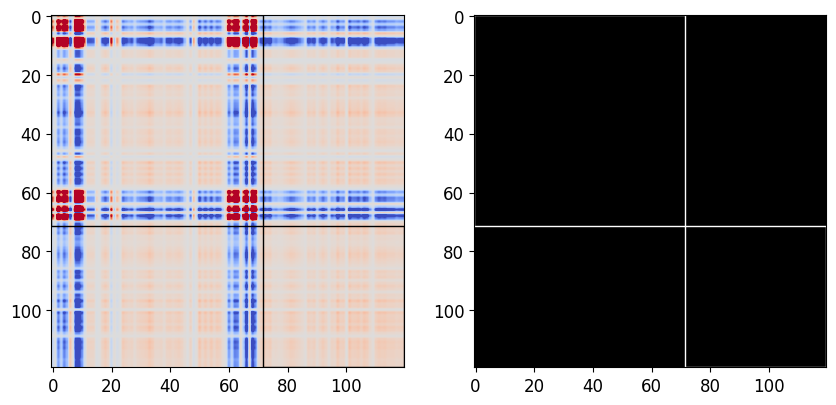

P-value: 0.320

100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 7086.14it/s]


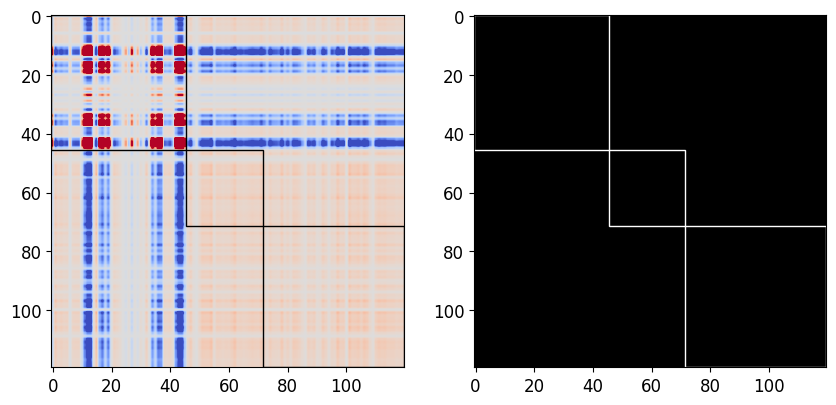

P-value: 0.103

100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 7149.00it/s]


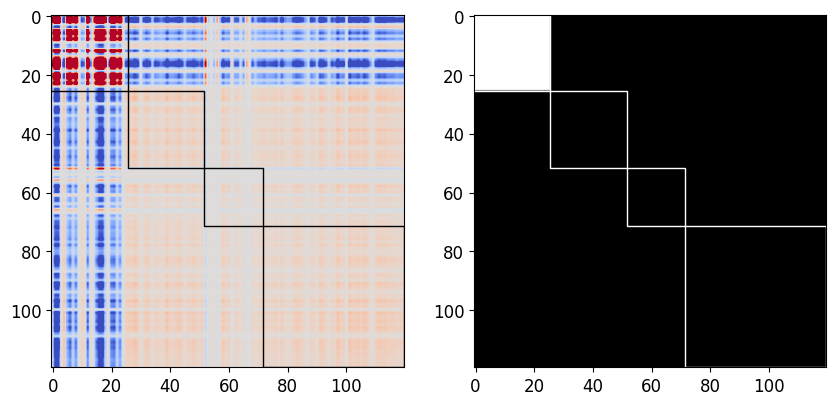

P-value: 0.026

100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 6637.04it/s]


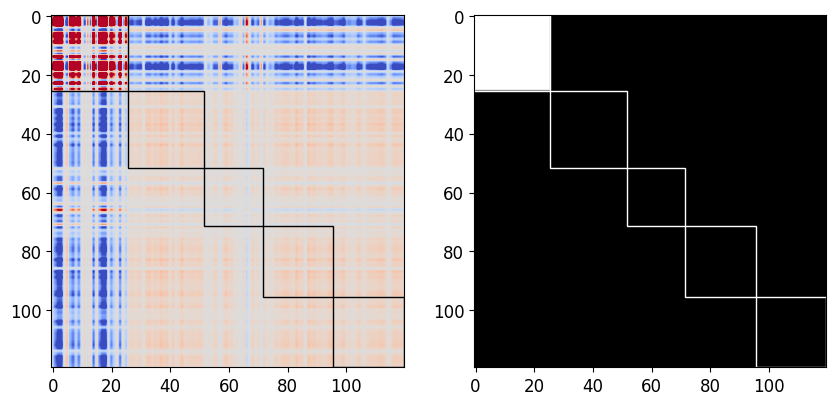

P-value: 0.046

100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 5988.42it/s]


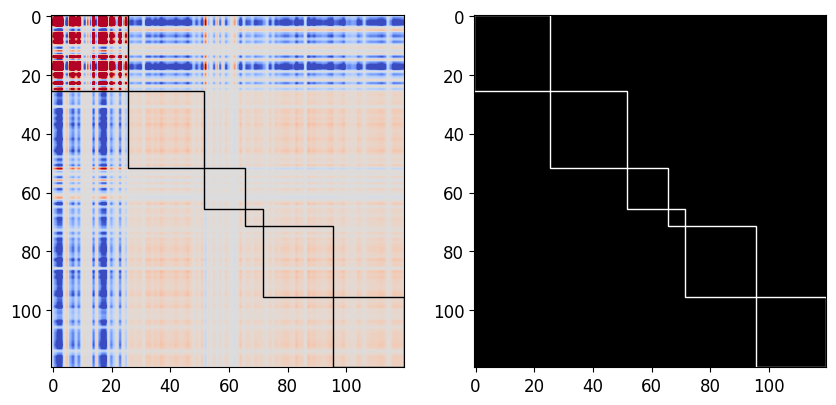

P-value: 0.068

100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 5912.40it/s]


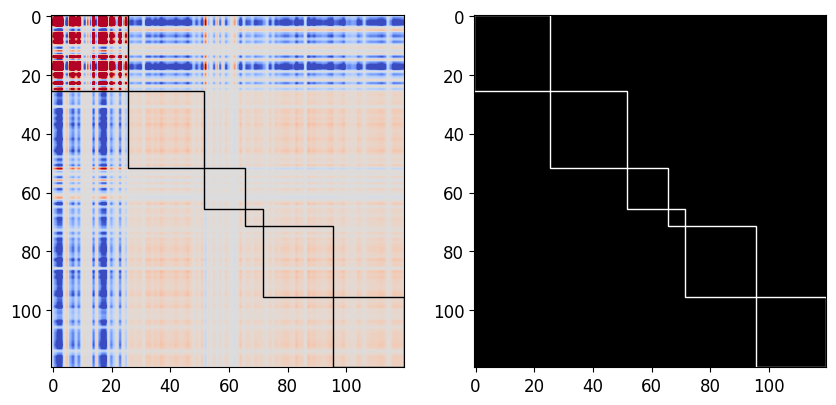

P-value: 0.068

100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 5260.78it/s]


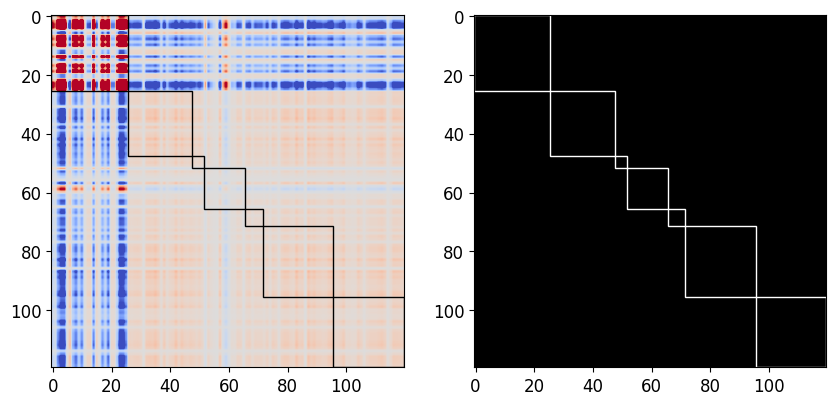

P-value: 0.132

100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4831.49it/s]


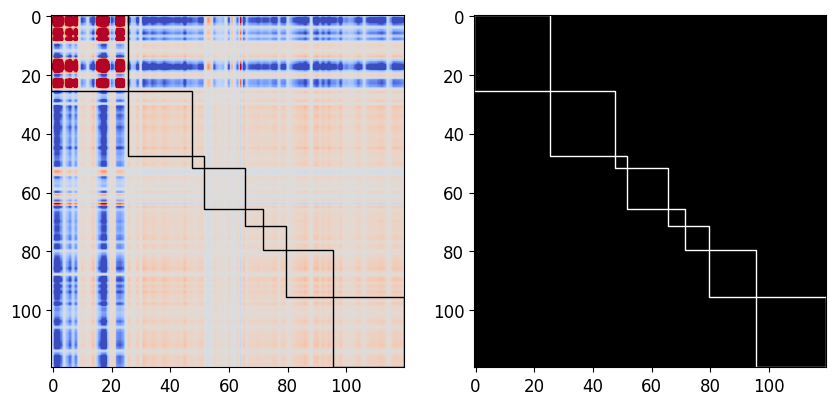

P-value: 0.139

100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4666.53it/s]


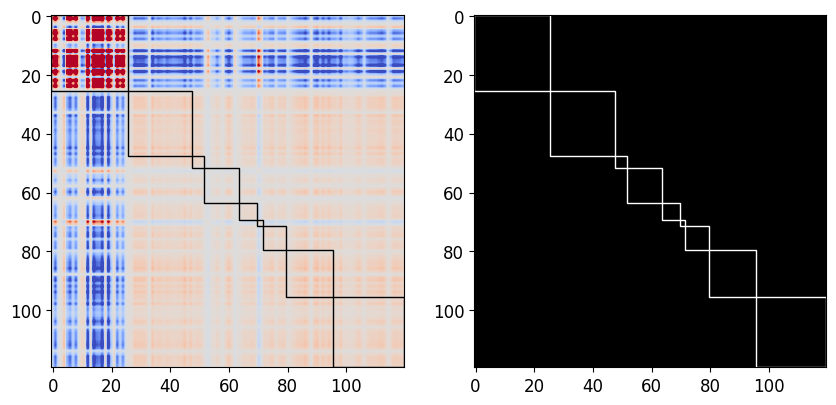

P-value: 0.205



In [57]:
for N_communities in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
    
    Z = linkage(1 - coassignment_matrix, 'ward')
    ids_Z = np.flip(leaves_list(Z)).astype('int')
    communities = reorder_clusters_anteroposterior(fcluster(Z, t=N_communities, criterion='maxclust'))
    communities = np.delete(double(communities), excluded)
    
    mean_coactivation = compute_mean_coactivation_per_module(c, communities)
    null_coactivations = []
    for s in tqdm(surrogates, file=sys.stdout):
        mean_null = compute_mean_coactivation_per_module(s, communities)
        null_coactivations.append(mean_null)
    threshold = np.percentile(np.max(null_coactivations, axis=1), 95)
    p_value = (100 - percentileofscore(np.max(null_coactivations, axis=1), np.max(mean_coactivation))) / 100
    significant = mean_coactivation > threshold
    plot_significant_modules(c, significant, communities, edgecolor='white')
    
    print('P-value: {:.3f}\n'.format(p_value))

Saving communities vectors for figure later

In [155]:
N_communities = 2
Z = linkage(1 - coassignment_matrix, 'ward')
ids_Z = np.flip(leaves_list(Z)).astype('int')
communities = reorder_clusters_anteroposterior(fcluster(Z, t=N_communities, criterion='maxclust'))
communities2 = np.delete(double(communities), excluded)

N_communities = 3
Z = linkage(1 - coassignment_matrix, 'ward')
ids_Z = np.flip(leaves_list(Z)).astype('int')
communities = reorder_clusters_anteroposterior(fcluster(Z, t=N_communities, criterion='maxclust'))
communities3 = np.delete(double(communities), excluded)

N_communities = 4
Z = linkage(1 - coassignment_matrix, 'ward')
ids_Z = np.flip(leaves_list(Z)).astype('int')
communities = reorder_clusters_anteroposterior(fcluster(Z, t=N_communities, criterion='maxclust'))
communities4 = np.delete(double(communities), excluded)

N_communities = 5
Z = linkage(1 - coassignment_matrix, 'ward')
ids_Z = np.flip(leaves_list(Z)).astype('int')
communities = reorder_clusters_anteroposterior(fcluster(Z, t=N_communities, criterion='maxclust'))
communities5 = np.delete(double(communities), excluded)

# Generating supplementary figure

Setting up some colors and colormaps

In [156]:
color1 = [0, 0, 0]
blue = hex2rgb('#006DAA')
color3 = [1, 1, 1]
red = np.array([205, 48, 112]) / 255

colormap = make_cmap([color1, blue, color3], [0, 0.5, 1])

cmap2 = 'rainbow'
colors = []
indices = np.linspace(0, 1, 4, endpoint=True)
for i in indices:
    colors.append(rgb2hex(np.array(plt.get_cmap(cmap2)(i)[:3])))
set_link_color_palette(colors)

Loading data and redefining some variables

In [157]:
atlas = MapzebrainAtlas(atlas_path)
centroids = np.concatenate([atlas.regionCentroids['left'], atlas.regionCentroids['right']], axis=0)
centroids[:, 1] = 974 - centroids[:, 1]
excluded = np.load('Results/excluded_regions.npy')
centroids_ = np.delete(centroids, np.concatenate([excluded, excluded + 70]), axis=0)

Generating the figure

4.834343841464752
4.459606879306583
0.32560854117779564


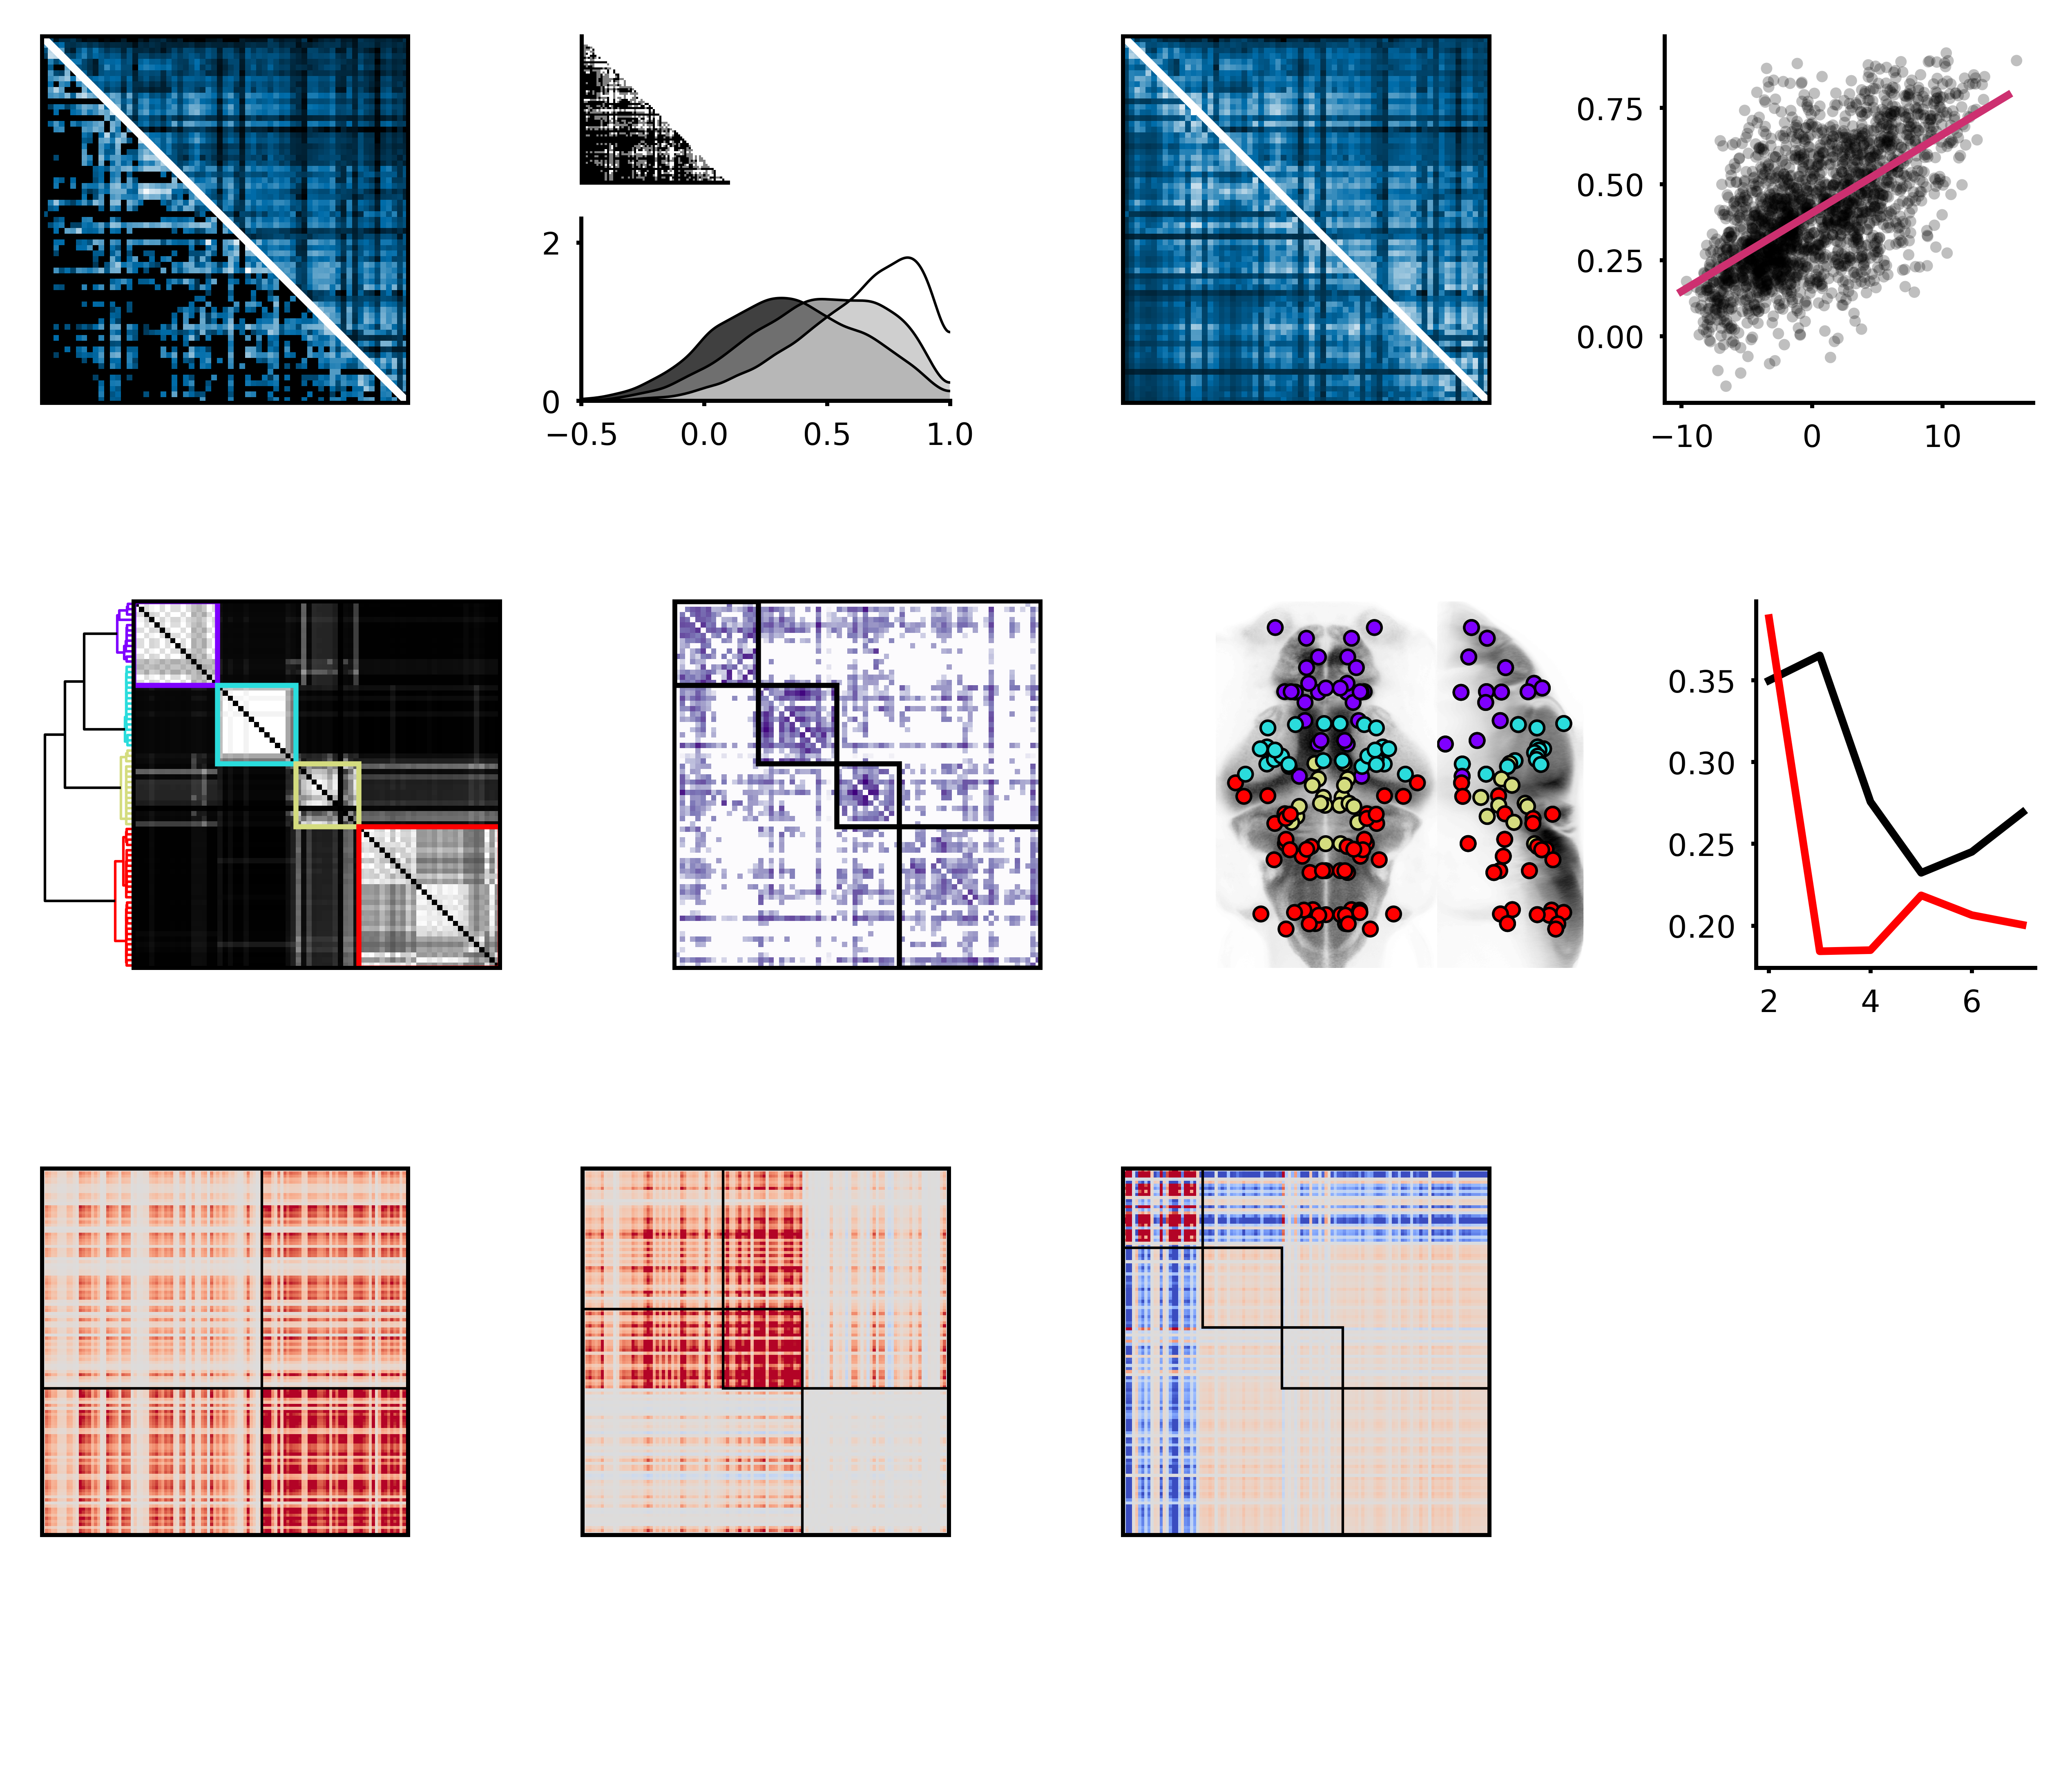

In [171]:
fig = PaperFigure(figsize=(7, 6), dpi=900)

fig.set_tick_length(1)
fig.set_font_size(6)
fig.add_background()

# Adding panels ------------------------------------------------------------

# Figure 2 stuff
w = 1.3
pad = (7 - 4 * w) / 3
fig.add_axes('SC_FC_comparison', (0, 0), w, w)
fig.add_axes('directionality', (w + pad, 0), 0.4 * w, 0.4 * w)
fig.add_axes('histograms', (w + pad, 0.5 * w), w, 0.5 * w)
fig.add_axes('structural_PC1', (2 * (w + pad), 0), w, w)
fig.add_axes('scatter_PC1', (3 * (w + pad), 0), w, w)

# Figure 3 stuff
fig.add_axes('dendrogram', (0, 2), w / 4, w)
fig.add_axes('coassignment', (w / 4, 2), w, w)
fig.add_axes('SC_matrix_communities', (1.25 * w + pad, 2), w, w)
fig.add_axes('modules_top', (0.25 * w + 2 * (w + pad), 2), 0.6 * w, w)
fig.add_axes('modules_side', (0.25 * w + 2 * (w + pad) + 0.6 * w, 2), 0.4 * w, w)
fig.add_axes('overlap_curves', (0.25 * w + 3 * (w + pad), 2), w, w)

# Figure 4 stuff
fig.add_axes('coactivation1', (0 * (w + pad), 4), w, w)
fig.add_axes('coactivation2', (1 * (w + pad), 4), w, w)
fig.add_axes('coactivation3', (2 * (w + pad), 4), w, w)


# Filling axes -------------------------------------------------------------

ax = fig.axes['SC_FC_comparison']
bbox = ax.get_position()
x0, y1 = bbox.x0, bbox.y1
matrix = normalize(delete(SC, excluded))
matrix[triangle] = normalize(np.copy(FC))[triangle]
cax = ax.imshow(matrix, cmap=colormap, vmin=0)
ax.plot([0, 64.5], [0, 64.5], color='white', linewidth=1.5)
ax.set_xticks([])
ax.set_yticks([])

ax = fig.axes['directionality']
matrix = np.copy(number_of_connections)
mask = np.triu_indices(matrix.shape[0], k=0)
masked_matrix = np.ma.array(matrix, mask=np.zeros_like(matrix))
masked_matrix[mask] = np.ma.masked
ax.imshow(masked_matrix, cmap='gray')
ax.spines[['top', 'right']].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

ax = fig.axes['histograms']
bins = np.linspace(-1, 1, 50)
plot_smooth_histogram(ax, corrs_0, bins, sigma=20, color='black', edgecolor='black', alpha=0.75, density=True, linewidth=0.5)
plot_smooth_histogram(ax, corrs_1, bins, sigma=20, color=[0.5, 0.5, 0.5], edgecolor='black', alpha=0.75, density=True, linewidth=0.5)
plot_smooth_histogram(ax, corrs_2, bins, sigma=20, color='white', edgecolor='black', alpha=0.5, density=True, linewidth=0.5)
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlim([-0.5, 1])
ax.set_ylim([0, 2.3])
ax.set_yticks([0, 2])

ax = fig.axes['structural_PC1']
bbox = ax.get_position()
x0, y1 = bbox.x0, bbox.y1
matrix = zscore_matrix(np.copy(PCs[0]))
matrix[triangle] = zscore_matrix(np.copy(FC))[triangle]
cax = ax.imshow(matrix, cmap=colormap)
ax.plot([0, 64.5], [0, 64.5], color='white', linewidth=1.5)
ax.set_xticks([])
ax.set_yticks([])

ax = fig.axes['scatter_PC1']
a, b = np.polyfit(PCs[0][triangle], FC[triangle], deg=1)
x = np.linspace(-10, 15)
ax.scatter(PCs[0][triangle], FC[triangle], color='black', s=5, alpha=0.25, edgecolor='None', rasterized=True)
ax.plot(x, a * x + b, color=red, linewidth=1.5)
ax.spines[['top', 'right']].set_visible(False)

N_communities = 4

ax = fig.axes['coassignment']
C = coassignment_matrix_SC
Z = linkage(1 - C, 'ward')
ids_Z = np.flip(leaves_list(Z)).astype('int')
communities_SC = reorder_clusters_anteroposterior(fcluster(Z, t=N_communities, criterion='maxclust'))
im = plot_matrix_communities(ax, C[ids_Z, :][:, ids_Z], communities_SC[ids_Z], linewidth=1, cmap='gray', colors=colors, edgecolor='red', output=True)
ax.set_xticks([])
ax.set_yticks([])

ax = fig.axes['dendrogram']
set_link_color_palette(list(np.flip(colors)))
ids_Z = leaves_list(Z)
threshold = Z[:, 2][-N_communities] + 1e-10
with plt.rc_context({'lines.linewidth': 0.5}):
    dendrogram(Z, ax=ax, above_threshold_color='black', orientation='left', color_threshold=threshold)
ax.axis('off')

ax = fig.axes['SC_matrix_communities']
im = plot_matrix_communities(ax, SC, communities_SC, linewidth=1, cmap='Purples', edgecolor='black', output=True)
ax.set_xticks([])
ax.set_yticks([])

ax = fig.axes['modules_top']
order = np.flip(np.argsort(centroids_[:, 2]))
ax.imshow(atlas.XYprojection, cmap='binary', aspect='auto')
ax.scatter(centroids_[order, 0], centroids_[order, 1], edgecolor='black', linewidth=0.5,
           color=double(np.array(colors)[np.delete(communities_SC, excluded) - 1])[order], cmap='rainbow', s=8)
ax.set_xlim([65, 505])
ax.set_ylim([850, 50])
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

ax = fig.axes['modules_side']
ax.imshow(np.rot90(atlas.XZprojection, k=3), cmap='binary', aspect='auto')
ax.scatter(359 - centroids_[:, 2], centroids_[:, 1], edgecolor='black', linewidth=0.5,
           color=double(np.array(colors)[np.delete(communities_SC, excluded) - 1]), cmap='rainbow', s=8)
ax.set_xlim([50, 359])
ax.set_ylim([850, 50])
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

ax = fig.axes['overlap_curves']
x = np.arange(2, N_max_FC + 1)
ax.plot(x, scores_empirical, color='black')
ax.plot(x, scores_99_SCCM, color='red')
ax.spines[['top', 'right']].set_visible(False)

ax = fig.axes['coactivation1']
R = cluster_centroids[0].shape[0]
cap = cluster_centroids[2].reshape(R, 1) @ cluster_centroids[2].reshape(1, R)
v = np.percentile(np.abs(cap), 95)
print(v)
plot_matrix_communities(ax, cap, communities2, vmin=-v, vmax=v, cmap='coolwarm', edgecolor='black', linewidth=0.5)
ax.set_xticks([])
ax.set_yticks([])

ax = fig.axes['coactivation2']
R = cluster_centroids[0].shape[0]
cap = cluster_centroids[1].reshape(R, 1) @ cluster_centroids[1].reshape(1, R)
v = np.percentile(np.abs(cap), 95)
print(v)
plot_matrix_communities(ax, cap, communities3, vmin=-v, vmax=v, cmap='coolwarm', edgecolor='black', linewidth=0.5)
ax.set_xticks([])
ax.set_yticks([])

ax = fig.axes['coactivation3']
R = cluster_centroids[0].shape[0]
cap = forebrain_active.reshape(R, 1) @ forebrain_active.reshape(1, R)
v = np.percentile(np.abs(cap), 95)
print(v)
plot_matrix_communities(ax, cap, communities4, vmin=-v, vmax=v, cmap='coolwarm', edgecolor='black', linewidth=0.5)
ax.set_xticks([])
ax.set_yticks([])

fig.show()

In [173]:
fig.save('/home/anleg84/Documents/Figures/PaperNetworks2024/Supplementary/supp_replicability_incomplete.svg')

Extra stats

In [174]:
from scipy.stats import f_oneway

In [180]:
corrs_0 = corrs_0[np.logical_not(np.isnan(corrs_0))]
corrs_1 = corrs_1[np.logical_not(np.isnan(corrs_1))]
corrs_2 = corrs_2[np.logical_not(np.isnan(corrs_2))]

In [181]:
f_value, p_value = f_oneway(corrs_0, corrs_1, corrs_2)
print(f'ANOVA results: F = {f_value}, p = {p_value}')

ANOVA results: F = 3219.3043815887327, p = 0.0
